In [1]:
import os
import cv2

def resize_all_images(folder_path, size=(128, 128)):
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, size)
            cv2.imwrite(img_path, img_resized)
        else:
            print(f"Failed to load {img_path}")

images_folder = 'data/preprocessed/train/images'  # update path as needed
masks_folder = 'data/preprocessed/train/masks'

resize_all_images(images_folder)
resize_all_images(masks_folder)

print("Resizing complete.")


Resizing complete.


In [2]:
sample_img = cv2.imread(os.path.join(images_folder, os.listdir(images_folder)[0]), cv2.IMREAD_GRAYSCALE)
sample_mask = cv2.imread(os.path.join(masks_folder, os.listdir(masks_folder)[0]), cv2.IMREAD_GRAYSCALE)

print(f"Sample image shape: {sample_img.shape}")
print(f"Sample mask shape: {sample_mask.shape}")


Sample image shape: (128, 128)
Sample mask shape: (128, 128)


# SPADE cGAN Training for Synthetic Fetal Head Ultrasound Images

In this notebook, we will use a SPADE conditional GAN to generate synthetic fetal head ultrasound images from segmentation masks. The goal is to improve the quantity and diversity of training data for segmentation.

## Data Requirements

SPADE cGAN requires paired datasets:
- Input: Segmentation masks (single-channel images)
- Output: Real ultrasound images (grayscale or RGB)
Both masks and real images must be the same size and filenames should match for correct pairing.


In [3]:
import os

# Specify your (preprocessed) images and masks directory paths
masks_dir = 'data/preprocessed/train/masks'
images_dir = 'data/preprocessed/train/images'

# List some sample filenames
mask_files = sorted(os.listdir(masks_dir))
image_files = sorted(os.listdir(images_dir))

print("First 5 mask files:", mask_files[:5])
print("First 5 image files:", image_files[:5])
print(f"Total masks: {len(mask_files)}, total images: {len(image_files)}")

# Optional: check if all images and masks match
all_match = all(m == i for m, i in zip(mask_files, image_files))
print("All filenames match between masks and images? ->", all_match)


First 5 mask files: ['100_2HC.png', '101_HC.png', '102_2HC.png', '103_HC.png', '104_HC.png']
First 5 image files: ['100_2HC.png', '101_HC.png', '102_2HC.png', '103_HC.png', '104_HC.png']
Total masks: 999, total images: 999
All filenames match between masks and images? -> True


## Image Size Checking

To train SPADE cGAN, all input masks and real images should have the same dimensions. In this step, we confirm that all images and masks are of consistent size.


In [4]:
import cv2

sample_mask = cv2.imread(os.path.join(masks_dir, mask_files[0]), cv2.IMREAD_GRAYSCALE)
sample_image = cv2.imread(os.path.join(images_dir, image_files[0]), cv2.IMREAD_GRAYSCALE)

print("Sample mask shape:", sample_mask.shape)
print("Sample image shape:", sample_image.shape)

# Check if ALL files are same size
all_same_size = True
expected_shape = sample_mask.shape

for f in mask_files:
    mask = cv2.imread(os.path.join(masks_dir, f), cv2.IMREAD_GRAYSCALE)
    if mask.shape != expected_shape:
        print(f"Mask {f} shape is {mask.shape}, expected {expected_shape}")
        all_same_size = False
        break

for f in image_files:
    img = cv2.imread(os.path.join(images_dir, f), cv2.IMREAD_GRAYSCALE)
    if img.shape != expected_shape:
        print(f"Image {f} shape is {img.shape}, expected {expected_shape}")
        all_same_size = False
        break

print("All images and masks have the expected shape? ->", all_same_size)


Sample mask shape: (128, 128)
Sample image shape: (128, 128)
All images and masks have the expected shape? -> True


## Dataset Class for SPADE cGAN Training

We define a PyTorch Dataset class to load paired masks and images for GAN training.  
Images and masks will be converted to tensors normalized between -1 and 1, which is typical for GANs.


In [5]:
from torch.utils.data import Dataset
import torch
import numpy as np
import os
import cv2

class FetalHeadGANData(Dataset):
    def __init__(self, images_dir, masks_dir, file_list):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        img_path = os.path.join(self.images_dir, file_name)
        mask_path = os.path.join(self.masks_dir, file_name)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

        # Normalize to [-1, 1]
        image = (image / 127.5) - 1.0
        mask = (mask / 127.5) - 1.0

        # Add channel dimension: [C,H,W]
        image = torch.tensor(image).unsqueeze(0)
        mask = torch.tensor(mask).unsqueeze(0)

        return mask, image  # mask is input; image is target


## Dataset Splitting and DataLoader Creation

Split the dataset into training and validation sets using an 80/20 ratio.  
Create DataLoader objects for efficient batching and shuffling during model training.


In [6]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os

masks_dir = 'data/preprocessed/train/masks'
images_dir = 'data/preprocessed/train/images'

all_files = sorted(os.listdir(masks_dir))

train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

train_dataset = FetalHeadGANData(images_dir, masks_dir, train_files)
val_dataset = FetalHeadGANData(images_dir, masks_dir, val_files)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)


print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Training samples: 799
Validation samples: 200


## SPADE cGAN Model Setup

We define a lightweight SPADE generator and discriminator optimized for single-channel (grayscale) fetal ultrasound images.  
The SPADE normalization conditions on segmentation masks for better context-aware image synthesis.  
The discriminator judges real vs fake images conditioned on masks.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SPADE(nn.Module):
    def __init__(self, norm_nc, label_nc):
        super().__init__()
        self.param_free_norm = nn.BatchNorm2d(norm_nc, affine=False)
        nhidden = 128
        self.mlp_shared = nn.Sequential(
            nn.Conv2d(label_nc, nhidden, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.mlp_gamma = nn.Conv2d(nhidden, norm_nc, kernel_size=3, padding=1)
        self.mlp_beta = nn.Conv2d(nhidden, norm_nc, kernel_size=3, padding=1)

    def forward(self, x, segmap):
        normalized = self.param_free_norm(x)
        segmap = F.interpolate(segmap, size=x.size()[2:], mode='nearest')
        actv = self.mlp_shared(segmap)
        gamma = self.mlp_gamma(actv)
        beta = self.mlp_beta(actv)
        out = normalized * (1 + gamma) + beta
        return out

class SPADEResnetBlock(nn.Module):
    def __init__(self, fin, fout, label_nc):
        super().__init__()
        self.learned_shortcut = (fin != fout)
        fmiddle = min(fin, fout)

        self.conv_0 = nn.Conv2d(fin, fmiddle, kernel_size=3, padding=1)
        self.conv_1 = nn.Conv2d(fmiddle, fout, kernel_size=3, padding=1)
        self.norm_0 = SPADE(fin, label_nc)
        self.norm_1 = SPADE(fmiddle, label_nc)
        if self.learned_shortcut:
            self.conv_s = nn.Conv2d(fin, fout, kernel_size=1, bias=False)
            self.norm_s = SPADE(fin, label_nc)

    def shortcut(self, x, seg):
        if self.learned_shortcut:
            x_s = self.norm_s(x, seg)
            x_s = self.conv_s(x_s)
            return x_s
        else:
            return x

    def forward(self, x, seg):
        x_s = self.shortcut(x, seg)
        dx = self.norm_0(x, seg)
        dx = F.relu(dx)
        dx = self.conv_0(dx)
        dx = self.norm_1(dx, seg)
        dx = F.relu(dx)
        dx = self.conv_1(dx)
        out = x_s + dx
        return out

class SPADEGenerator(nn.Module):
    def __init__(self, label_nc, ngf=16, z_dim=256):
        super().__init__()
        self.z_dim = z_dim
        self.ngf = ngf
        self.fc = nn.Linear(z_dim, 16 * ngf * 16 * 16)

        self.head_0 = SPADEResnetBlock(16 * ngf, 16 * ngf, label_nc)
        self.G_middle_0 = SPADEResnetBlock(16 * ngf, 16 * ngf, label_nc)
        self.G_middle_1 = SPADEResnetBlock(16 * ngf, 16 * ngf, label_nc)
        self.up_0 = SPADEResnetBlock(16 * ngf, 8 * ngf, label_nc)
        self.up_1 = SPADEResnetBlock(8 * ngf, 4 * ngf, label_nc)

        self.conv_img = nn.Conv2d(4 * ngf, 1, kernel_size=3, padding=1)
        self.up = nn.Upsample(scale_factor=2)

    def forward(self, seg, z):
        x = self.fc(z).view(-1, 16 * self.ngf, 16, 16)
        x = self.head_0(x, seg)
        x = self.up(x)   # 32x32
        x = self.G_middle_0(x, seg)
        x = self.G_middle_1(x, seg)
        x = self.up(x)   # 64x64
        x = self.up_0(x, seg)
        x = self.up(x)   # 128x128
        x = self.up_1(x, seg)
        x = self.conv_img(F.relu(x))
        x = torch.tanh(x)
        return x

class MultiscaleDiscriminator(nn.Module):
    def __init__(self, input_nc=2, ndf=64, n_layers=3):
        super().__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_nc, ndf, normalize=False),
            *discriminator_block(ndf, ndf * 2),
            *discriminator_block(ndf * 2, ndf * 4),
            *discriminator_block(ndf * 4, ndf * 8),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, padding=1)
        )

    def forward(self, x):
        return self.model(x)


## Model Initialization and Optimizer Setup

We initialize the SPADE generator and discriminator models, move them to the device (GPU if available), and define their optimizers and loss functions for GAN training.


In [4]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

label_nc = 1  # grayscale masks

netG = SPADEGenerator(label_nc=label_nc, ngf=8, z_dim=256).to(device)
netD = MultiscaleDiscriminator(input_nc=2).to(device)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and m.weight is not None:
        if classname.find('Conv') != -1 or classname.find('Linear') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm2d') != -1 or classname.find('InstanceNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)

netG.apply(weights_init_normal)
netD.apply(weights_init_normal)

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_pixelwise = nn.L1Loss()

optimizer_G = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(netD.parameters(), lr=0.0004, betas=(0.5, 0.999))

print("Models initialized and optimizers ready.")


Models initialized and optimizers ready.


## SPADE cGAN Training Loop

The training loop alternates between updating the generator and discriminator.  
The generator tries to fool the discriminator and produce realistic images conditioned on masks, while the discriminator tries to distinguish real from fake image-mask pairs.  
Loss is computed using adversarial loss (BCE with logits) and pixelwise L1 loss for image fidelity.


In [5]:
def train_epoch(netG, netD, dataloader, optimizer_G, optimizer_D, criterion_GAN, criterion_pixelwise, device):
    netG.train()
    netD.train()

    G_losses = []
    D_losses = []

    for i, (masks, real_imgs) in enumerate(dataloader):
        masks = masks.to(device)
        real_imgs = real_imgs.to(device)
        batch_size = masks.size(0)

        optimizer_G.zero_grad()
        z = torch.randn(batch_size, netG.z_dim, device=device)
        fake_imgs = netG(masks, z)

        pred_fake = netD(torch.cat((masks, fake_imgs), dim=1))
        valid = torch.ones_like(pred_fake, device=device)
        loss_GAN = criterion_GAN(pred_fake, valid)

        loss_pixel = criterion_pixelwise(fake_imgs, real_imgs)

        loss_G = loss_GAN + 100 * loss_pixel
        loss_G.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        pred_real = netD(torch.cat((masks, real_imgs), dim=1))
        fake = torch.zeros_like(pred_real, device=device)
        loss_D_real = criterion_GAN(pred_real, valid)
        pred_fake = netD(torch.cat((masks, fake_imgs.detach()), dim=1))
        loss_D_fake = criterion_GAN(pred_fake, fake)
        loss_D = 0.5 * (loss_D_real + loss_D_fake)
        loss_D.backward()
        optimizer_D.step()

        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

    avg_G_loss = sum(G_losses) / len(G_losses)
    avg_D_loss = sum(D_losses) / len(D_losses)
    return avg_G_loss, avg_D_loss


## Multi-Epoch Training Loop with Checkpointing

This loop will train the SPADE cGAN for a set number of epochs, printing losses every epoch.  
Model checkpoints will be saved periodically for backup and later use.


In [11]:
import os

def save_checkpoint(model, optimizer, epoch, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

num_epochs = 50  # or adjust

checkpoint_dir = "checkpoints_spade"
best_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    avg_G_loss, avg_D_loss = train_epoch(netG, netD, train_loader,
                                        optimizer_G, optimizer_D,
                                        criterion_GAN, criterion_pixelwise, device)

    print(f"Epoch [{epoch}/{num_epochs}] - Generator loss: {avg_G_loss:.4f}, Discriminator loss: {avg_D_loss:.4f}")

    # Save checkpoint every 10 epochs or on improved loss
    if epoch % 10 == 0 or avg_G_loss < best_loss:
        save_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}.pth")
        save_checkpoint(netG, optimizer_G, epoch, save_path)
        best_loss = avg_G_loss
        print(f"Checkpoint saved at epoch {epoch}")


Epoch [1/50] - Generator loss: 26.3388, Discriminator loss: 0.2243
Checkpoint saved at epoch 1
Epoch [2/50] - Generator loss: 24.4113, Discriminator loss: 0.3544
Checkpoint saved at epoch 2
Epoch [3/50] - Generator loss: 24.7120, Discriminator loss: 0.3524
Epoch [4/50] - Generator loss: 24.8764, Discriminator loss: 0.3352
Epoch [5/50] - Generator loss: 25.0297, Discriminator loss: 0.3165
Epoch [6/50] - Generator loss: 25.0681, Discriminator loss: 0.2972
Epoch [7/50] - Generator loss: 25.1680, Discriminator loss: 0.3241
Epoch [8/50] - Generator loss: 25.2355, Discriminator loss: 0.3078
Epoch [9/50] - Generator loss: 25.1799, Discriminator loss: 0.3130
Epoch [10/50] - Generator loss: 25.3169, Discriminator loss: 0.2988
Checkpoint saved at epoch 10
Epoch [11/50] - Generator loss: 25.1488, Discriminator loss: 0.3067
Checkpoint saved at epoch 11
Epoch [12/50] - Generator loss: 25.1522, Discriminator loss: 0.2966
Epoch [13/50] - Generator loss: 25.4022, Discriminator loss: 0.2927
Epoch [14/5

## Visualizing Generated Synthetic Images

It is important to periodically inspect the synthetic images produced by the SPADE generator during training. This visualization shows side-by-side comparisons of:

- Input segmentation masks,  
- The corresponding generated synthetic fetal ultrasound images,  
- The real ultrasound images from the validation set.

Images are normalized back from the range [-1, 1] to [0, 1] for proper display. Visual inspection helps confirm that the generator learns meaningful features and realistic image generation progresses as training advances.


In [6]:
import matplotlib.pyplot as plt
import torch

def visualize_generated_samples(netG, val_loader, device, num_samples=4):
    """
    Generate and display synthetic images alongside input masks and real images.

    Args:
        netG: Trained SPADE generator model.
        val_loader: DataLoader for validation dataset.
        device: torch device (cpu or cuda).
        num_samples: Number of samples to visualize.
    """
    netG.eval()
    with torch.no_grad():
        masks, real_imgs = next(iter(val_loader))
        masks = masks.to(device)
        z = torch.randn(masks.size(0), netG.z_dim, device=device)
        fake_imgs = netG(masks, z)

        # Convert tensors from [-1,1] to [0,1] for visualization
        def to_img(tensor):
            img = (tensor.squeeze(1).cpu() + 1) / 2  
            return img.clamp(0,1)

        plt.figure(figsize=(12, num_samples * 4))
        for i in range(min(num_samples, masks.size(0))):
            plt.subplot(num_samples, 3, 3*i + 1)
            plt.title('Mask')
            plt.imshow(to_img(masks[i]), cmap='gray')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, 3*i + 2)
            plt.title('Generated')
            plt.imshow(to_img(fake_imgs[i]), cmap='gray')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, 3*i + 3)
            plt.title('Real')
            plt.imshow(to_img(real_imgs[i]), cmap='gray')
            plt.axis('off')
        plt.show()


## Integrating Visualization with Training

To conveniently monitor generator progress, insert a call to the visualization function at regular intervals during training.

The following code snippet should be placed inside the multi-epoch training loop, for example after epoch loss logging:



## Loading Model Checkpoints

For resuming training or conducting inference, loading model and optimizer states from saved checkpoints is essential.

The function below handles the loading process and returns the epoch from which training can continue.

Using checkpoints helps in managing long training sessions with interruptions or iterative fine-tuning.


In [7]:
def load_checkpoint(model, optimizer, path, device):
    """
    Load model and optimizer states from checkpoint.

    Args:
        model: PyTorch model to load.
        optimizer: Optimizer associated with the model.
        path: Path to checkpoint file (.pth).
        device: torch device where model resides.

    Returns:
        start_epoch: Epoch number after checkpoint.
    """
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    return start_epoch


## Synthetic Dataset Generation

This section generates a synthetic dataset of fetal ultrasound images using the trained SPADE generator model.  
Given a folder of segmentation masks, the generator produces corresponding synthetic images, which are saved to disk.

This synthetic dataset can then be used for downstream tasks like super-resolution, ROI detection, and segmentation.


In [8]:
# Import libraries and set device

import os
import torch
from torchvision.utils import save_image
from torchvision import transforms
from PIL import Image
from tqdm import tqdm  # For progress bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


### Load Trained SPADE Generator Model

Initialize the SPADE generator with your training parameters and load the saved weights from checkpoint.  
Set the model to evaluation mode to disable training-specific layers during synthetic image generation.


In [9]:
# Initialize SPADE generator and load checkpoint

netG = SPADEGenerator(label_nc=label_nc, ngf=8, z_dim=256).to(device)

checkpoint_path = 'checkpoints_spade/model_epoch_50.pth'  # Update if needed
checkpoint = torch.load(checkpoint_path, map_location=device)
netG.load_state_dict(checkpoint['model_state_dict'])
netG.eval()
print("Loaded SPADE generator checkpoint.")


C:\Users\MANISH\AppData\Local\Temp\ipykernel_25396\1338739796.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

Loaded SPADE generator checkpoint.


### Prepare Segmentation Masks for Generation

Set the folder containing segmentation mask images and define preprocessing transforms matching your training pipeline.  
Collect all mask file paths for batch processing.


In [14]:
mask_dir = './data/preprocessed/train/masks/'
output_dir = './synthetic_dataset/'
os.makedirs(output_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')]
print(f'Found {len(mask_paths)} masks for synthetic image generation.')


Found 999 masks for synthetic image generation.


In [15]:
import torch
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm

# Assume device and netG (trained SPADE generator) already defined and loaded

output_dir = './synthetic_dataset/'
os.makedirs(output_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

with torch.no_grad():
    for mask_path in tqdm(mask_paths):
        mask_img = Image.open(mask_path).convert('L')  # Load grayscale mask image
        mask_tensor = transform(mask_img).unsqueeze(0).to(device)  # Preprocess and add batch dim
        
        z = torch.randn(1, netG.z_dim, device=device)  # Random noise vector
        
        fake_img = netG(mask_tensor, z)  # Generate synthetic image (range [-1,1])
        
        fake_img_vis = (fake_img + 1) / 2  # Normalize to [0,1] for saving
        
        base_name = os.path.basename(mask_path)
        save_path = os.path.join(output_dir, base_name.replace('.png', '_fake.png'))
        
        save_image(fake_img_vis, save_path)


100%|████████████████████████████████████| 999/999 [00:52<00:00, 18.90it/s]


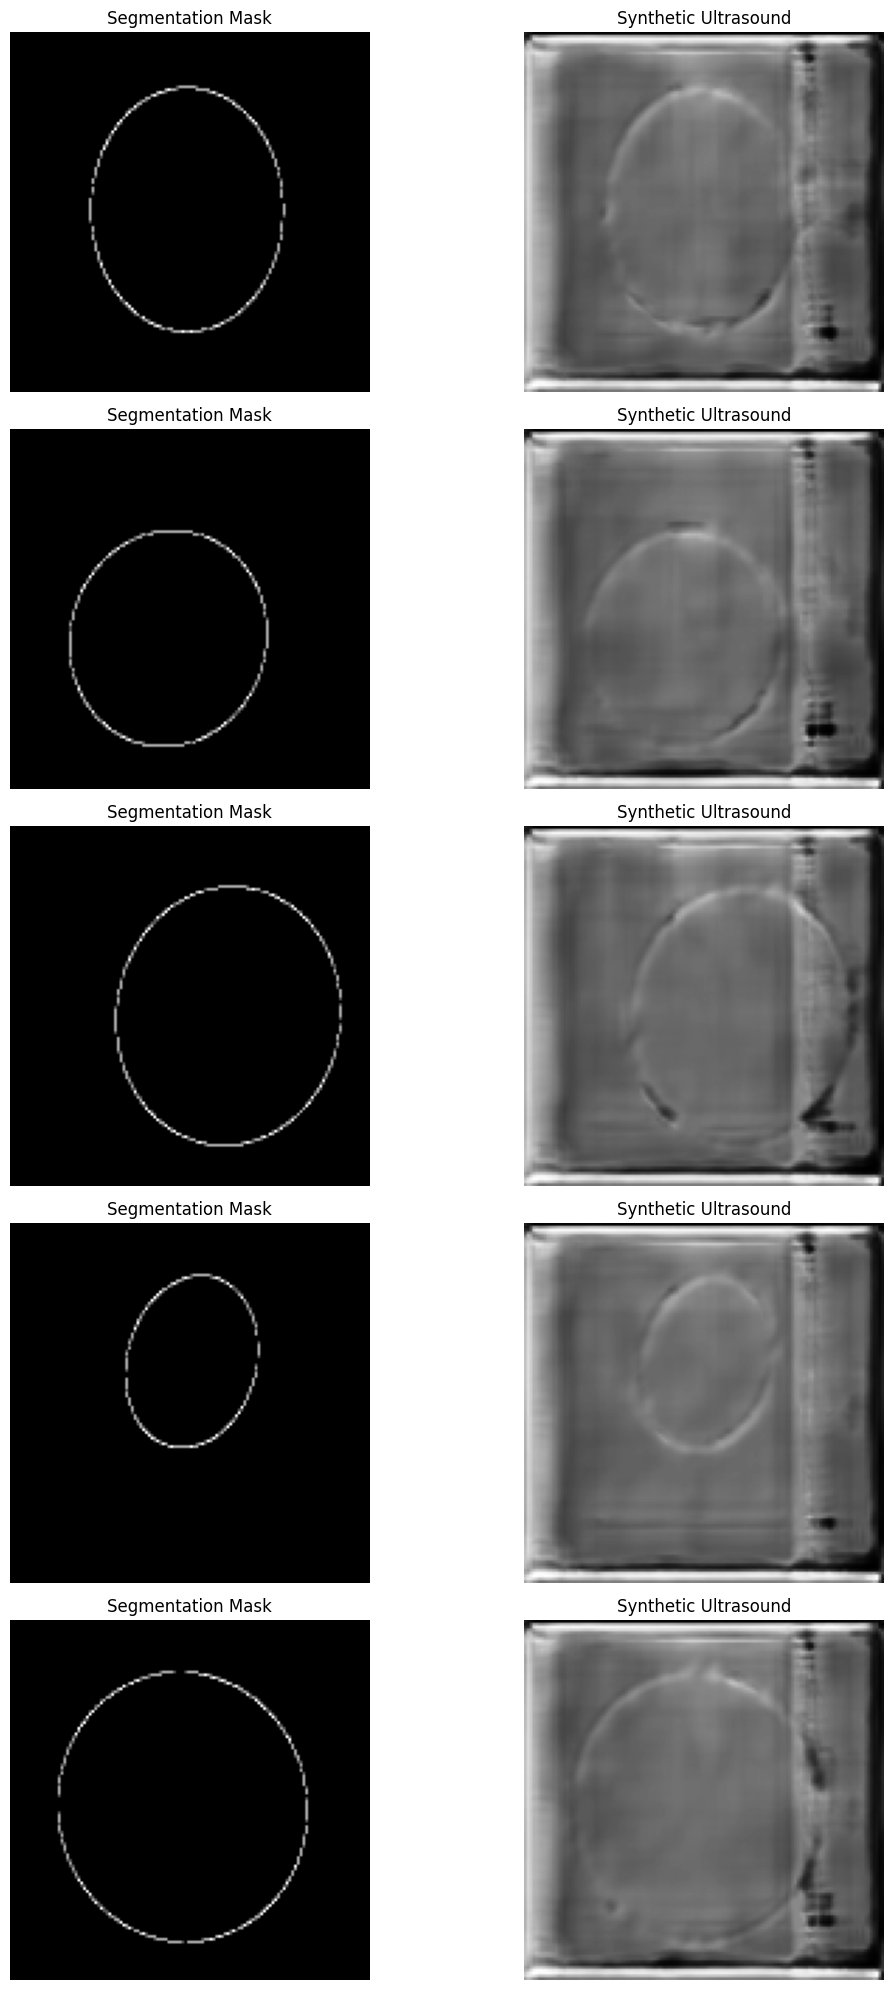

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Number of samples to visualize
num_samples = 5

# Randomly select mask image paths to visualize
sample_paths = random.sample(mask_paths, num_samples)

plt.figure(figsize=(12, num_samples * 4))

for i, mask_path in enumerate(sample_paths):
    # Load and display the mask
    mask_img = Image.open(mask_path).convert('L')
    
    # Load the corresponding generated synthetic image
    base_name = os.path.basename(mask_path).replace('.png', '_fake.png')
    synthetic_img_path = os.path.join(output_dir, base_name)
    synthetic_img = Image.open(synthetic_img_path).convert('L')
    
    # Plot mask
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(mask_img, cmap='gray')
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    # Plot synthetic image
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(synthetic_img, cmap='gray')
    plt.title('Synthetic Ultrasound')
    plt.axis('off')

plt.tight_layout()
plt.show()
